In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import binary_closing, binary_dilation, binary_erosion, binary_opening
from numpy.fft import fft2, fftshift, ifft2, ifftshift, rfft2, irfft2
import matplotlib.patches as patches
import skimage.restoration as restore
import cv2 
from scipy.ndimage import map_coordinates
from IPython import display
import time

In [148]:
def drawnow(fig):
    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(.01)

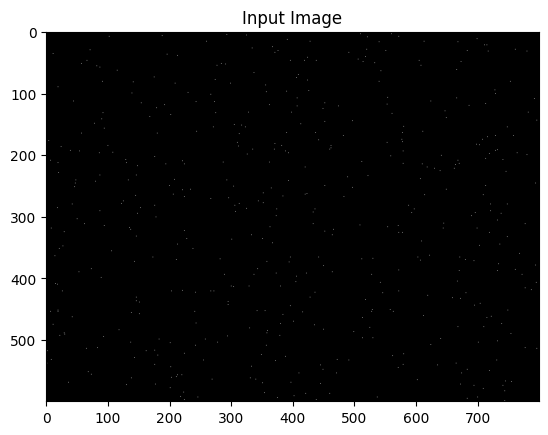

In [8]:
img = plt.imread("synthetic/random_1px.png")

if len(img.shape) > 2:
    print("Converting image to grayscale")
    img = img.mean(axis=2)

plt.imshow(img, cmap="gray")
plt.title("Input Image")
plt.show()

# Polar Transforms

In [19]:
def polar_transform(img, center, output=None):
    r = (np.array(img.shape[:2])**2).sum()**0.5/2

    if output is None:
        shp = int(round(r)), int(round(r*2*np.pi))
        output = np.zeros(shp, dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    
    out_h, out_w = output.shape
    r_samples = np.linspace(0, r, out_h)
    theta_samples = np.linspace(0, np.pi*2, out_w)
    
    xs = r_samples[:,None] * np.cos(theta_samples) + center[1]
    ys = r_samples[:,None] * np.sin(theta_samples) + center[0]
    
    map_coordinates(img, (ys, xs), order=1, output=output)
    return output

In [20]:
def inverse_polar_transform(img, center, output=None):
    r = img.shape[0]
    
    if output is None:
        output = np.zeros((r*2, r*2), dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    
    out_h, out_w = output.shape
    
    y_samples, x_samples = np.mgrid[:out_h, :out_w]
    y_samples -= center[0]
    x_samples -= center[1]
    
    rs = (y_samples * y_samples + x_samples * x_samples) **0.5
    ts = np.arccos(x_samples / (rs + 1e-8))
    ts[y_samples<0] = np.pi * 2 - ts[y_samples<0]
    ts *= (img.shape[1]-1) / (np.pi * 2)
    
    map_coordinates(img, (rs, ts), order=1, output=output)
    return output

# Synthetic Trail Gen

In [21]:
coded_center = (300, 400)

In [22]:
def generate_star_trails(img, kernel):
    return convolve2d(img, kernel, mode='same')

In [55]:
kernel = np.ones((1, 500)) / 500

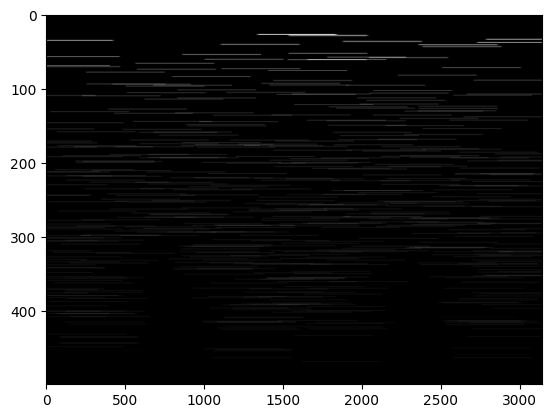

In [56]:
star_trail_img = generate_star_trails(polar_transform(img, center=coded_center), kernel)

plt.imshow(star_trail_img, cmap='gray', aspect='auto')
plt.show()

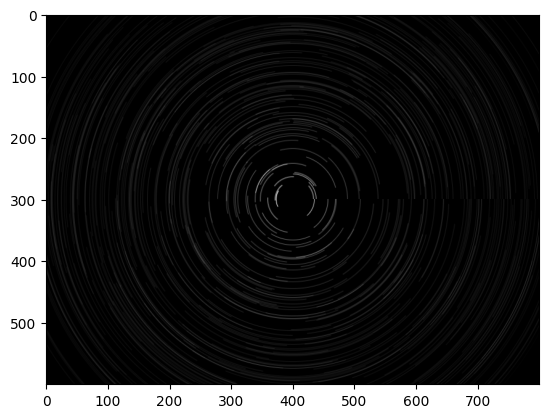

In [57]:
blurred_img = inverse_polar_transform(star_trail_img, center=coded_center, output=img.shape)

plt.imshow(blurred_img, cmap='gray')
plt.show()

In [72]:
def contrast_stetch(img):
    max = img.max()
    min = img.min()
    return (img - min) / (max - min)

# Center 

In [73]:
def find_center(img):

    # Binarize Image
    img = contrast_stetch(img)
    bin_img = (img > 0.25).astype('int')
    print(bin_img.max())

    H, W = img.shape[:2]
    factor = 1
    if (H > 1000 or W > 1000):
        factor = max(H, W) // 1000

    # Dilating and subsampling
    bin_img = binary_dilation(bin_img, np.ones((factor, factor)))
    bin_img = bin_img[::factor, ::factor].astype(np.uint8) * 255
    
    # To remove noise
    blur = cv2.GaussianBlur(bin_img, ksize=(31, 31), sigmaX=1)

    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, minDist=200, param1=50, param2=30, minRadius=10, maxRadius=0)
    circles = np.around(circles).reshape((-1, 3))
    
    # Create a figure. Equal aspect so circles look circular
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(img, cmap="gray")

    for circ in circles[:1]:
        ax.add_patch(patches.Circle(circ[:2] * factor, circ[2], edgecolor='r', linewidth=1, fill=False))
        ax.add_patch(patches.Rectangle(circ[:2] * factor, 20*factor, 20*factor))

    # Show the image
    plt.show()
    
    circ[1::-1] = circ[:2]
    print("Predicted Center: ", circ[:2] * factor)
    return circ[:2] * factor
    
    

1


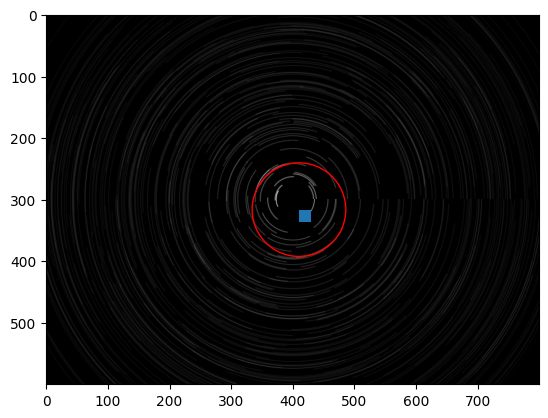

Predicted Center:  [316. 410.]


In [77]:
center = find_center(blurred_img)

# Deconv

In [72]:
def estimate_deblurring_kernel(img, time):
    '''
    time: (in minutes) the duration of exposure
    '''
    H, W = img.shape[:2]
    r = (np.array(img.shape[:2])**2).sum()**0.5/2
    total_theta = int(round(2 * np.pi * r))
    estimated_theta = total_theta * (time / (24 * 60))
    estimated_theta = np.around(estimated_theta).astype('int')

    estimated_kernel = np.zeros((1, total_theta)) # Is it correct though?
    estimated_kernel[0, :estimated_theta] = 1 / estimated_theta

    return estimated_kernel

In [78]:
# kernel = estimate_deblurring_kernel(img, time=80)

print(kernel.shape, np.sum(kernel))

(1, 500) 1.0000000000000004


## Wiener Decovolution

In [79]:
def wiener_deconvolution(image, psf, nsr=0.01):
    """
    image (np.array) : MxN
    psf (np.array)  : MxN 
    nsr (noise to signal ratio - 1/SNR from above derivation) : float
    """
    # YOUR CODE HERE
    deblurred_image = np.zeros_like(image)
    Y = fftshift(fft2(image))
    H = fftshift(fft2(psf))
    X = Y * np.conj(H) / (nsr + np.conj(H) * H)
    deblurred_image = ifftshift(ifft2(X))
    deblurred_image = np.abs(deblurred_image)
    return deblurred_image

In [80]:
psf = np.zeros_like(star_trail_img)
kh, kw = kernel.shape
H, W = psf.shape
psf[H//2-kh//2:H//2-kh//2+kh, W//2-kw//2:W//2-kw//2+kw] = kernel

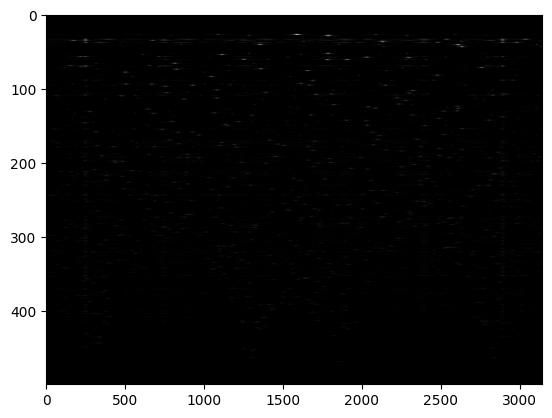

In [81]:
wiener_out = wiener_deconvolution(star_trail_img, psf, nsr=1e-3)

plt.imshow(wiener_out, aspect='auto', cmap='gray')
plt.show()

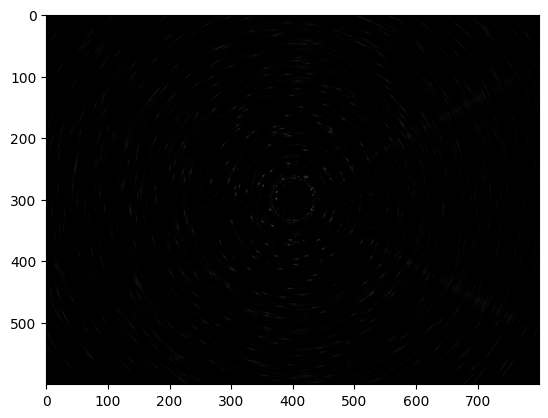

In [85]:
img_recon_wiener = inverse_polar_transform(wiener_out, center=(300, 400), output=img.shape)

plt.imshow(contrast_stetch(img_recon_wiener), cmap='gray')

## Richardson Lucy

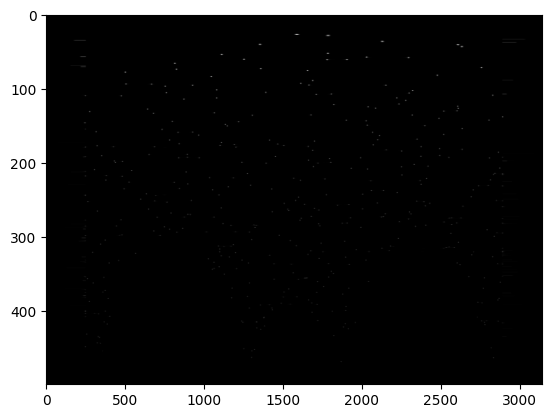

In [98]:
rl_out = restore.richardson_lucy(star_trail_img, kernel, num_iter=200)

plt.imshow(rl_out, cmap='gray', aspect='auto')
plt.show()

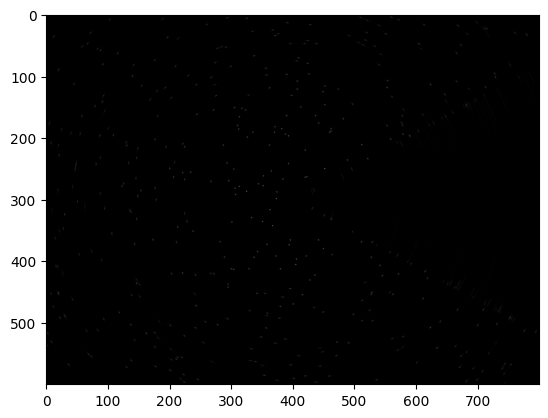

In [99]:
img_recon_rl = inverse_polar_transform(rl_out, center=(300, 400), output=img.shape)

plt.imshow(contrast_stetch(img_recon_rl), cmap='gray')
plt.show()

## Vanilla GD

In [133]:
def F(x):
    return rfft2(x,axes=(0,1))

def Fh(x):
    return irfft2(x,axes=(0,1))

In [142]:
def crop(x):
    M,N = x.shape
    rl = M//4
    ru = 3*np.ceil(M/4)
    cl = N//4
    cu = 4*np.ceil(N/4)
    return x[M//4:3*M//4, N//4:3*N//4]

def pad(psf, x):
    M, N = x.shape    
    pad_psf = np.zeros((2*H, 2*W))
    pad_psf[M//2:M//2+psf.shape[0], N//2:N//2+psf.shape[1]] = psf
    return pad_psf

In [143]:
def A(x, pad_psf):
    H_bar = F(ifftshift(pad_psf))
    H = np.real(Fh(H_bar * F(x)))
    return crop(H)   

def Ah(y, pad_psf):
    H = F(ifftshift(pad_psf))
    H_star = np.conj(H)
    return np.real(Fh(H_star*F(pad(y, y))))

In [144]:
## Testing the implemented functions.
[M,N] = star_trail_img.shape
x = np.random.rand(2*M, 2*N)
y = np.random.rand(M,N)
pad_psf = pad(kernel, x)

Ax_y = np.sum(A(x, pad_psf)*y)
x_Ahy = np.sum(x*Ah(y, pad_psf))

## They should have the same value.
print('<A(x),y> =',Ax_y)
print('<x,Ah(y)>=',x_Ahy)


<A(x),y> = 391978.0543252421
<x,Ah(y)>= 391978.0543252419


KeyboardInterrupt: 

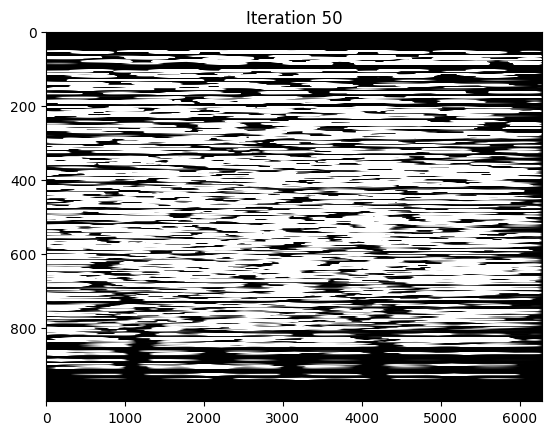

In [154]:
n_iters = 500   #Number of iterations
x_k = np.zeros((2*M, 2*N))   #Initialize with zeros
mu = 1    #Step size

fig = plt.figure()   #Initialize figure
im_obj = plt.imshow(x_k, cmap='gray', aspect='auto')  
title_obj = plt.title('Iteration {}'.format(0))

for k in range(n_iters):
    x_k = x_k - mu * Ah(A(x_k, pad_psf) - star_trail_img, pad_psf)
    
    ## Display progress
    if k%10 == 0:
        im_obj.set_data(np.maximum(crop(x_k)/np.max(x_k),0))
        plt.title('Iteration {}'.format(k))
        drawnow(fig)

x_gd = x_k

im_obj.set_data(np.maximum(crop(x_k)/np.max(x_k),0))
plt.title('Iteration {}'.format(k))

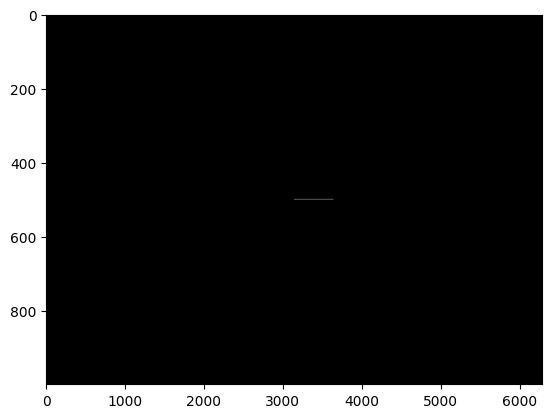

In [153]:
plt.imshow(pad_psf, cmap='gray', aspect='auto')